# Counting Crowds with Deep Learning
## Proof Of Concept

The notebook will implement various papers for the puprose of crowd counting
* [Dense Scale Networks](https://arxiv.org/pdf/1906.09707.pdf)
* [CSRNet: Dilated Convolutional Neural Networks](https://arxiv.org/pdf/1802.10062.pdf)

The goal - to find the best approach to teach a model to count crowds, based on input images.

## 1. Imports

In [3]:
import os
import cv2
import glob
import random
import numpy as np
import scipy.io
import h5py
import collections
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from skimage import exposure, img_as_float
import logging
import warnings
warnings.filterwarnings("ignore")

In [4]:
# reporting module
from ovreport.report import report_to_overwatch

### 1.1 Globals
A number of parameters on top of the notebook

In [5]:
# Dataset Paths
train_path_UCF_QNRF = 'training_dataset/UCF-QNRF_ECCV18/Train_h5/'
test_path_UCF_QNRF = 'training_dataset/UCF-QNRF_ECCV18/Test_h5/'
train_path_SGH = 'training_dataset/ShanghaiTech/train_h5/'
test_path_SGH = 'training_dataset/ShanghaiTech/test_h5/'
# TODO: Add More ... add more

# Target Image Size
TARGET_SHAPE = (720, 480)

# Model save paths
BEST_MODEL_SAVE_PATH = 'models/best/'
CKP_MODEL_SAVE_PATH = 'models/checkpoints/'
# Training Details
PRETRAINED_BACKBONE = True
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1
EPOCHS = 50
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4

### 1.2 Dealing with Data

In [6]:
class RawDataset(Dataset):
    def __init__(self, root, transform, ratio=8, output_shape=False, aug=False):
        self.nsamples = len(root)
        self.aug = aug
        self.output_shape = output_shape
        self.root = root
        self.ratio = ratio
        self.transform = transform
    
    def __augment(image, target, count, seed):
        random.seed(seed)
        
        # apply random crop
        if random.random() < 0.5:
            crop_size = (img.size[0]//2, img.size[1]//2)
        
            if random.random() <=0.44:
                # 4 non-overlapping patches
                dx = int(random.randint(0,1) * crop_size[0])
                dy = int(random.randint(0,1) * crop_size[1])
            else:
                # 5 random patches
                # set seed to ensure for each image the random patches are certain
                # if not set, the crop will be online which means the patches change every time loading, leading to a dynamic training set.
                patch_id = random.randint(0, 4)
                random.seed(index + patch_id * 0.1)
                dx = int(random.random() * crop_size[0])
                random.seed(index + 0.5 + patch_id * 0.1)
                dy = int(random.random() * crop_size[1])
            # crop
            img = img.crop((dx, dy, crop_size[0]+dx, crop_size[1]+dy))
            target = target[dy:crop_size[1]+dy, dx:crop_size[0]+dx]
            count = float(target.sum())
        
        if random.random() > 0.5:
            target = np.fliplr(target)
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        if random.random() > 0.7:
            img = img_as_float(image)
            # gamma_img: np.array(dtype=float64) ranging [0,1]
            if random.random() > 0.5:
                gamma_img = exposure.adjust_gamma(img, 1.5)
            else:
                gamma_img = exposure.adjust_gamma(img, 0.5)
            gamma_img = gamma_img * 255
            gamma_img = np.uint8(gamma_img)
            image = Image.fromarray(gamma_img)
        
        return image, target, count
    
    def __resize_to_target(self, img, target_shape):
        return cv2.resize(img, target_shape, interpolation=cv2.INTER_CUBIC)
    
    def __load_data(self, path, ratio=8, output_shape=None, aug=False, index=None):
        src_h5 = h5py.File(path, 'r')
        img = src_h5['image_array'].value
        output = src_h5['density_map'].value
        count = float(src_h5['count'].value)


        if len(img.shape) < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        if output_shape is not None:
            img = self.__resize_to_target(img, output_shape)
            output = self.__resize_to_target(output, output_shape)

        if aug:
            # TODO: Implement augumentation
            img, output, count = self.__augment(img, output, count, 42)

        if self.ratio>1:
            output = cv2.resize(output, 
                                (int(output.shape[1]/ratio),int(output.shape[0]/ratio)), 
                                interpolation=cv2.INTER_CUBIC) * (ratio**2)

        output = np.reshape(output, (1, ) + output.shape)

        return img, output, count        
    
    def __getitem__(self, index):
        img, target, count = self.__load_data(self.root[index], output_shape=self.output_shape, aug=self.aug)
        if self.transform:
            img = self.transform(img)
        return img, target, count
    
    def __len__(self):
        return self.nsamples

In [7]:
def get_loaders(train_path, test_path, output_shape, ratio=8):
    train_img_paths = glob.glob(os.path.join(train_path, '*.h5'))
    test_img_paths = glob.glob(os.path.join(test_path, '*.h5'))
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset = RawDataset(train_img_paths, transform, ratio=ratio, output_shape=output_shape, aug=False)
    test_dataset = RawDataset(test_img_paths, transform, ratio=ratio, output_shape=output_shape, aug=False)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=TEST_BATCH_SIZE)
    
    return train_loader, test_loader

In [8]:
train_loader, test_loader = get_loaders(train_path_SGH, test_path_SGH, output_shape=TARGET_SHAPE)
train_loader2, test_loader2 = get_loaders(train_path_SGH, test_path_SGH, output_shape=TARGET_SHAPE, ratio=1)

In [9]:
# train_loader, test_loader = get_loaders(train_path_UCF_QNRF, test_path_UCF_QNRF, output_shape=TARGET_SHAPE)
# train_loader2, test_loader2 = get_loaders(train_path_UCF_QNRF, test_path_UCF_QNRF, output_shape=TARGET_SHAPE, ratio=1)

### 1.3 Utilities

#### 1.3.1 Model Checkpoints
Save model checkpoints, which are - epoch number, model state and optimizer state. A model checkpoint will be saved only whenever a better MAE is achieved or each 5 epochs, only if the previous loss has been improved.

In [10]:
def save_checkpoint(epoch, model_filename, model_state_dict, optimizer_state_dict, save_path):
    '''
        Saves the model, as well as the optimizer state in the predefined place.
    '''
    print('Saving Model!')
    state = {
        'epoch': epoch,
        'state_dict': model_state_dict,
        'optimizer': optimizer_state_dict
    }
    
    torch.save(state, os.path.join(save_path, model_filename))

In [11]:
def load_checkpoint(checkpoint_filepath, model, optimizer):
    '''
        Loads the model from checkpoint_filepath.
    '''    
    state = torch.load(checkpoint_filepath)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    epoch = state['epoch']
    return epoch, model, optimizer

## 2. Dense Scale Network

### 2.1 The Model

In [12]:
class DDCB(nn.Module):
    '''
        TODO: Docstring
    '''
    def __init__(self, in_planes):
        super(DDCB, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=1), nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes+64, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=2, dilation=2), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_planes+128, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=3, dilation=3), nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_planes+128, 512, 3, padding=1), nn.ReLU(True))
    def forward(self, x):
        x1_raw = self.conv1(x)
        x1 = torch.cat([x, x1_raw], 1)
        x2_raw = self.conv2(x1)
        x2 = torch.cat([x, x1_raw, x2_raw], 1)
        x3_raw = self.conv3(x2)
        x3 = torch.cat([x, x2_raw, x3_raw], 1)
        output = self.conv4(x3)
        return output

In [13]:
class DenseScaleNet(nn.Module):
    '''
        TODO: Docstring
    '''
    def __init__(self, model_state='', pretrained_backbone=False, trainable_backbone=False):
        super(DenseScaleNet, self).__init__()
        self.model_state = model_state
        self.pretrained_backbone = pretrained_backbone
        self.trainable_backbone = trainable_backbone
        # network
        self.features = self.__get_backbone()
        self.DDCB1 = DDCB(512)
        self.DDCB2 = DDCB(512)
        self.DDCB3 = DDCB(512)
        self.output_layers = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1), 
                                           nn.ReLU(True), 
                                           nn.Conv2d(128, 64, 3, padding=1), 
                                           nn.ReLU(True), 
                                           nn.Conv2d(64, 1, 1))
        self.__initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x1_raw = self.DDCB1(x)
        x1 = x1_raw + x
        x2_raw = self.DDCB2(x1)
        x2 = x2_raw + x1_raw + x
        x3_raw = self.DDCB3(x2)
        x3 = x3_raw + x2_raw + x1_raw + x
        output = self.output_layers(x3)
        return output
    
    def __get_backbone(self):
        self.features_cfg = [64, 64, 'M', 
                             128, 128, 'M', 
                             256, 256, 256, 'M', 
                             512, 512, 512,]
        return self.__make_layers(self.features_cfg, batch_norm=True)
    
    def __make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)   
    
    def __initialize_weights(self):
        self_dict = self.state_dict()
        pretrained_dict = dict()
        self.__random_initialize_weights()
        if not self.model_state:
            # load vgg16
            vgg16 = torchvision.models.vgg16(pretrained=self.pretrained_backbone)
            # check if the backbone should be trainable or not
            if not self.trainable_backbone:
                for param in vgg16.parameters():
                    param.requires_grad = False
            # copy over the items that match        
            for k, v in vgg16.state_dict().items():
                if k in self_dict and self_dict[k].size() == v.size():
                    pretrained_dict[k] = v
            self_dict.update(pretrained_dict)
            self.load_state_dict(self_dict)
        else:
            self_dict.update(self.model_state)
            self.load_state_dict(self_dict)
            
    def __random_initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, std=0.01)
                #nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

### 2.2 Criterion, Loss

In [14]:
criterion = nn.MSELoss()

In [15]:
def cal_lc_loss(output, target, sizes=(1,2,4)):
    criterion_L1 = nn.L1Loss()
    Lc_loss = None
    for s in sizes:
        pool = nn.AdaptiveAvgPool2d(s)
        est = pool(output)
        gt = pool(target)
        if Lc_loss:
            Lc_loss += criterion_L1(est, gt)
        else:
            Lc_loss = criterion_L1(est, gt)
    return Lc_loss

In [16]:
def calc_loss(output, target):
    Le_Loss = criterion(output, target)
    Lc_Loss = cal_lc_loss(output, target)
    loss = Le_Loss + 1000 * Lc_Loss
    return loss

In [17]:
def val(model, test_loader):
    model.eval()
    mae = 0.0
    mse = 0.0
    with torch.no_grad():
        for img, target, count in test_loader:
            img = img.cuda()
            output = model(img)
            est_count = output.sum().item()
            mae += abs(est_count - count)
            mse += (est_count - count)**2
    mae /= len(test_loader)
    mse /= len(test_loader)
    mse = mse**0.5
    return float(mae), float(mse)

### 2.3 Init Model

In [18]:
dsn_net = DenseScaleNet('', pretrained_backbone=True, trainable_backbone=False)
dsn_net.cuda()

DenseScaleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2

### 2.4 Optimizer

In [19]:
optimizer = torch.optim.Adam(dsn_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### 2.5 Training Loop

In [20]:
def train_model(model, optimizer, train_loader, test_loader, 
                resume_training=False, saved_model_filepath=''):
    '''
        TODO: Docstring
    '''
    init_epoch = 0
    if resume_training:
        init_epoch, model, optimizer = load_checkpoint(saved_model_filepath)
    
    
    best_mae, _  = val(model, test_loader)
    
    for epoch in range(init_epoch, EPOCHS+init_epoch):
        train_loss = 0.0
        model.train()
        for img, target, count in tqdm(train_loader):
            optimizer.zero_grad()
            img = img.cuda()
            target = target.float()
            target = target.cuda()
            output = model(img)

            loss = calc_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        mae, mse = val(model, test_loader)

        print('Epoch {}/{} Loss:{:.3f}, MAE:{:.2f}, MSE:{:.2f}, Best MAE:{:.2f}'.format(epoch+1, 
                                                                                        EPOCHS, 
                                                                                        train_loss/len(train_loader), 
                                                                                        mae, 
                                                                                        mse, 
                                                                                        best_mae))
        if (epoch + 1) % 5 == 0:
            save_checkpoint(epoch, f'DenseScaleNet_noaug_e{epoch}_{LEARNING_RATE}.pth', 
                            model.state_dict(), 
                            optimizer.state_dict(), 
                            CKP_MODEL_SAVE_PATH)          
        
        if mae < best_mae:
            best_mae = mae
            print(f'New best mae: {best_mae}. Saving model!')
            # report best model
            report_to_overwatch('VM:ML:P', 'Atlas', f'Epoch {epoch} recorded {best_mae}!')
            
            save_checkpoint(epoch, 'DenseScaleNet_noaug_1e-5.pth', 
                            model.state_dict(), 
                            optimizer.state_dict(), 
                            BEST_MODEL_SAVE_PATH)
    
    return model

### 2.6 Training the model

In [19]:
dsn_net = train_model(dsn_net, optimizer, train_loader, test_loader)
report_to_overwatch('VM:ML:P', 'Atlas', 'Training of model done!')

100%|██████████| 400/400 [02:10<00:00,  3.07it/s]


Epoch 1/50 Loss:81.857, MAE:139.57, MSE:211.78, Best MAE:175.42
New best mae: 139.57226107373268. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2/50 Loss:68.524, MAE:145.56, MSE:419.18, Best MAE:139.57


100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


Epoch 3/50 Loss:63.685, MAE:127.49, MSE:221.85, Best MAE:139.57
New best mae: 127.49276928179249. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4/50 Loss:58.647, MAE:137.86, MSE:292.27, Best MAE:127.49


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5/50 Loss:55.857, MAE:142.03, MSE:261.44, Best MAE:127.49


100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


Epoch 6/50 Loss:56.871, MAE:125.59, MSE:215.65, Best MAE:127.49
New best mae: 125.59297523864463. Saving model!
200
Report sent
Saving Model!


100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


Epoch 7/50 Loss:54.025, MAE:121.08, MSE:243.61, Best MAE:125.59
New best mae: 121.07701945455769. Saving model!
200
Report sent
Saving Model!


100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


Epoch 8/50 Loss:51.533, MAE:118.95, MSE:232.67, Best MAE:121.08
New best mae: 118.94577198044126. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9/50 Loss:49.616, MAE:134.36, MSE:397.27, Best MAE:118.95


100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


Epoch 10/50 Loss:54.119, MAE:111.01, MSE:178.79, Best MAE:118.95
New best mae: 111.01066358293158. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 11/50 Loss:45.252, MAE:134.66, MSE:394.62, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 12/50 Loss:44.378, MAE:148.07, MSE:228.46, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13/50 Loss:40.833, MAE:145.23, MSE:217.31, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14/50 Loss:39.958, MAE:117.90, MSE:330.47, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15/50 Loss:40.884, MAE:136.07, MSE:204.24, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16/50 Loss:38.047, MAE:125.01, MSE:204.58, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17/50 Loss:40.195, MAE:115.89, MSE:246.90, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18/50 Loss:35.132, MAE:166.15, MSE:245.71, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19/50 Loss:35.768, MAE:114.71, MSE:398.17, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20/50 Loss:33.844, MAE:121.88, MSE:188.58, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 21/50 Loss:37.275, MAE:114.55, MSE:199.38, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22/50 Loss:30.828, MAE:114.48, MSE:214.62, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23/50 Loss:31.420, MAE:115.90, MSE:260.87, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24/50 Loss:32.478, MAE:122.32, MSE:211.80, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25/50 Loss:31.222, MAE:127.09, MSE:245.98, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26/50 Loss:27.590, MAE:129.09, MSE:258.56, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27/50 Loss:26.879, MAE:130.51, MSE:208.25, Best MAE:111.01


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 28/50 Loss:25.798, MAE:120.65, MSE:201.81, Best MAE:111.01


100%|██████████| 400/400 [02:09<00:00,  3.09it/s]


Epoch 29/50 Loss:25.663, MAE:109.89, MSE:190.29, Best MAE:111.01
New best mae: 109.89214397118062. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 30/50 Loss:27.131, MAE:132.72, MSE:213.21, Best MAE:109.89


100%|██████████| 400/400 [02:09<00:00,  3.09it/s]


Epoch 31/50 Loss:28.160, MAE:87.91, MSE:182.49, Best MAE:109.89
New best mae: 87.90837595960762. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 32/50 Loss:24.883, MAE:110.41, MSE:172.04, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 33/50 Loss:24.530, MAE:108.47, MSE:176.09, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 34/50 Loss:23.727, MAE:112.19, MSE:187.36, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 35/50 Loss:21.765, MAE:106.63, MSE:244.93, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 36/50 Loss:22.607, MAE:114.78, MSE:184.86, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 37/50 Loss:22.723, MAE:123.34, MSE:200.77, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 38/50 Loss:23.326, MAE:96.32, MSE:199.02, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 39/50 Loss:21.190, MAE:112.13, MSE:195.99, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 40/50 Loss:21.259, MAE:105.89, MSE:225.68, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 41/50 Loss:23.843, MAE:115.10, MSE:184.13, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 42/50 Loss:20.490, MAE:146.10, MSE:220.85, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 43/50 Loss:20.164, MAE:100.67, MSE:190.57, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 44/50 Loss:18.954, MAE:97.62, MSE:175.50, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 45/50 Loss:22.077, MAE:117.23, MSE:195.45, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 46/50 Loss:20.310, MAE:127.22, MSE:197.93, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 47/50 Loss:18.444, MAE:127.92, MSE:194.45, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 48/50 Loss:20.770, MAE:146.48, MSE:218.31, Best MAE:87.91


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 49/50 Loss:20.436, MAE:134.22, MSE:203.97, Best MAE:87.91


100%|██████████| 400/400 [02:09<00:00,  3.09it/s]


Epoch 50/50 Loss:21.900, MAE:143.63, MSE:217.34, Best MAE:87.91
200
Report sent


### 2.7 Testing

In [22]:
# load the model
epoch, dsn_net, optimizer = load_checkpoint('models/best/DenseScaleNet_noaug_1e-5.pth', 
                                            dsn_net, 
                                           optimizer)

In [50]:
src_h5 = h5py.File('training_dataset/ShanghaiTech/test_h5/train_h5GT_IMG_213.mat.h5', 'r')
img = src_h5['image_array'].value
output = src_h5['density_map'].value
count = float(src_h5['count'].value)

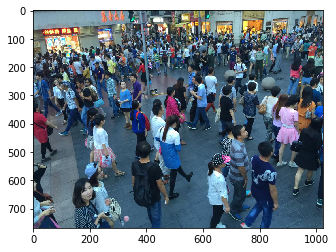

In [51]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [52]:
img = cv2.resize(img, (720, 480), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 3, 480, 720))
timg = torch.from_numpy(img).float().cuda()

In [53]:
output = dsn_net(timg)

In [54]:
output.sum().item()

301.5592346191406

In [55]:
count

284.0

## 3. Congested Scene Recognition Network

### 3.1 The Model

In [56]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False, trainable_backbone=False):
        super(CSRNet, self).__init__()
        self.trainable_backbone = trainable_backbone
        self.frontend_feat = [64, 64, 'M', 128, 128,
                              'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = self.__make_layers(self.frontend_feat, batch_norm=True)
        self.backend = self.__make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        self.__initialize_weights()

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = nn.functional.interpolate(x, scale_factor=8)
        return x

    def __initialize_weights(self):
        self_dict = self.state_dict()
        pretrained_dict = dict()
        # load vgg16
        vgg16 = torchvision.models.vgg16(pretrained=True)
        # check if the backbone should be trainable or not
        if self.trainable_backbone:
            for param in vgg16.parameters():
                param.requires_grad = False
        # copy over the items that match        
        for k, v in vgg16.state_dict().items():
            if k in self_dict and self_dict[k].size() == v.size():
                pretrained_dict[k] = v
        self_dict.update(pretrained_dict)
        self.load_state_dict(self_dict)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
    def __make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3,
                                   padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

### 3.2 Criterion
Same as Dense Scale Net

In [57]:
criterion = nn.MSELoss(size_average=False)

### 3.3 Init Model

In [58]:
csr_net = CSRNet()
csr_net.cuda()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 

### 3.4 Optimizer

In [59]:
optimizer = torch.optim.Adam(csr_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 

### 3.5 Train Loop

In [14]:
def train_model(model, optimizer, criterion, train_dataloader, test_dataloader):
    min_mae = 999999
    min_mae_epoch = -1
    for epoch in range(EPOCHS):                          # start training
        model.train()
        epoch_loss = 0.0
        for img, target, count in tqdm(train_dataloader):
            image = img.cuda()
            gt_densitymap = target.float()
            gt_densitymap = gt_densitymap.cuda()
            et_densitymap = model(image)  
            loss = criterion(et_densitymap,gt_densitymap)       # calculate loss
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()                                     # back propagation
            optimizer.step()                                    # update network parameters
            
        print('Epoch {}/{} Loss: {:.3f}'.format(epoch+1, EPOCHS, epoch_loss/len(train_loader)))

        model.eval()
        
        with torch.no_grad():
            epoch_mae = 0.0
            for img, target, count in test_dataloader:
                image = img.cuda()
                target = target.float()
                gt_densitymap = target.cuda()
                et_densitymap = model(image).detach()           # forward propagation
                mae = abs(et_densitymap.data.sum()-gt_densitymap.data.sum())
                epoch_mae += mae.item()
            epoch_mae /= len(test_dataloader)
            print('Epoch {}/{} MAE: {:.3f}'.format(epoch, EPOCHS, epoch_mae))
            if epoch_mae < min_mae:
                min_mae, min_mae_epoch = epoch_mae, epoch
                report_to_overwatch('VM:ML:P', 'Atlas', f'Epoch {epoch} recorded {min_mae}!')

                save_checkpoint(epoch, 'CSRNet_no_aug_e'+str(epoch)+".pth", 
                                model.state_dict(), 
                                optimizer.state_dict(), 
                                BEST_MODEL_SAVE_PATH)                

    return model

### 3.6 Training the model.

In [15]:
csr_net = train_model(csr_net, optimizer, criterion, train_loader2, test_loader2)
report_to_overwatch('VM:ML:P', 'Atlas', 'Training of CSRNet model done!')

100%|██████████| 400/400 [07:09<00:00,  1.07s/it]


Epoch 1/50 Loss: 1.725
Epoch 0/50 MAE: 128.548


  0%|          | 0/400 [00:00<?, ?it/s]

200
Report sent
Saving Model!


100%|██████████| 400/400 [07:13<00:00,  1.08s/it]


Epoch 2/50 Loss: 1.582
Epoch 1/50 MAE: 51.771
200
Report sent
Saving Model!


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 3/50 Loss: 1.567
Epoch 2/50 MAE: 51.112
200
Report sent
Saving Model!


100%|██████████| 400/400 [07:13<00:00,  1.08s/it]


Epoch 4/50 Loss: 1.450


  0%|          | 1/400 [00:00<00:49,  8.03it/s]

Epoch 3/50 MAE: 57.027


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 5/50 Loss: 1.436


  0%|          | 1/400 [00:00<00:49,  8.02it/s]

Epoch 4/50 MAE: 55.113


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 6/50 Loss: 1.434


  0%|          | 1/400 [00:00<00:50,  7.87it/s]

Epoch 5/50 MAE: 62.157


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 7/50 Loss: 1.389


  0%|          | 1/400 [00:00<00:49,  8.11it/s]

Epoch 6/50 MAE: 119.845


100%|██████████| 400/400 [07:13<00:00,  1.08s/it]


Epoch 8/50 Loss: 1.373


  0%|          | 1/400 [00:00<00:49,  8.05it/s]

Epoch 7/50 MAE: 87.865


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 9/50 Loss: 1.324


  0%|          | 1/400 [00:00<00:51,  7.79it/s]

Epoch 8/50 MAE: 69.109


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 10/50 Loss: 1.300
Epoch 9/50 MAE: 48.530


  0%|          | 0/400 [00:00<?, ?it/s]

200
Report sent
Saving Model!


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 11/50 Loss: 1.323


  0%|          | 1/400 [00:00<00:49,  8.10it/s]

Epoch 10/50 MAE: 104.540


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 12/50 Loss: 1.185


  0%|          | 1/400 [00:00<00:50,  7.98it/s]

Epoch 11/50 MAE: 54.995


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 13/50 Loss: 1.296


  0%|          | 1/400 [00:00<00:52,  7.63it/s]

Epoch 12/50 MAE: 75.324


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 14/50 Loss: 1.182


  0%|          | 1/400 [00:00<00:49,  8.14it/s]

Epoch 13/50 MAE: 65.303


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 15/50 Loss: 1.196


  0%|          | 1/400 [00:00<00:49,  8.06it/s]

Epoch 14/50 MAE: 51.290


100%|██████████| 400/400 [07:11<00:00,  1.08s/it]


Epoch 16/50 Loss: 1.184


  0%|          | 1/400 [00:00<00:49,  8.08it/s]

Epoch 15/50 MAE: 56.136


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 17/50 Loss: 1.157


  0%|          | 1/400 [00:00<00:49,  8.08it/s]

Epoch 16/50 MAE: 89.997


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 18/50 Loss: 1.125


  0%|          | 1/400 [00:00<00:49,  8.07it/s]

Epoch 17/50 MAE: 72.614


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 19/50 Loss: 1.102


  0%|          | 1/400 [00:00<00:49,  8.04it/s]

Epoch 18/50 MAE: 60.999


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 20/50 Loss: 1.091


  0%|          | 1/400 [00:00<00:49,  8.09it/s]

Epoch 19/50 MAE: 74.180


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 21/50 Loss: 1.149


  0%|          | 1/400 [00:00<00:50,  7.96it/s]

Epoch 20/50 MAE: 63.490


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 22/50 Loss: 1.057


  0%|          | 1/400 [00:00<00:51,  7.74it/s]

Epoch 21/50 MAE: 63.383


100%|██████████| 400/400 [07:11<00:00,  1.08s/it]


Epoch 23/50 Loss: 1.095


  0%|          | 1/400 [00:00<00:49,  8.09it/s]

Epoch 22/50 MAE: 68.465


100%|██████████| 400/400 [07:11<00:00,  1.08s/it]


Epoch 24/50 Loss: 1.025


  0%|          | 1/400 [00:00<00:49,  8.04it/s]

Epoch 23/50 MAE: 69.325


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 25/50 Loss: 1.000


  0%|          | 1/400 [00:00<00:50,  7.94it/s]

Epoch 24/50 MAE: 67.849


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 26/50 Loss: 0.978


  0%|          | 1/400 [00:00<00:49,  8.14it/s]

Epoch 25/50 MAE: 64.099


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 27/50 Loss: 0.984


  0%|          | 1/400 [00:00<00:49,  8.11it/s]

Epoch 26/50 MAE: 53.613


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 28/50 Loss: 1.011


  0%|          | 1/400 [00:00<00:49,  8.01it/s]

Epoch 27/50 MAE: 61.622


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 29/50 Loss: 0.964


  0%|          | 1/400 [00:00<00:49,  8.06it/s]

Epoch 28/50 MAE: 53.111


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 30/50 Loss: 0.918


  0%|          | 1/400 [00:00<00:50,  7.96it/s]

Epoch 29/50 MAE: 80.094


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 31/50 Loss: 0.920


  0%|          | 1/400 [00:00<00:50,  7.96it/s]

Epoch 30/50 MAE: 80.936


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 32/50 Loss: 0.920


  0%|          | 1/400 [00:00<00:49,  7.99it/s]

Epoch 31/50 MAE: 69.981


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 33/50 Loss: 0.907


  0%|          | 1/400 [00:00<00:50,  7.95it/s]

Epoch 32/50 MAE: 67.439


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 34/50 Loss: 0.888


  0%|          | 1/400 [00:00<00:49,  8.12it/s]

Epoch 33/50 MAE: 91.911


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 35/50 Loss: 0.851


  0%|          | 1/400 [00:00<00:49,  8.13it/s]

Epoch 34/50 MAE: 77.455


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 36/50 Loss: 0.854


  0%|          | 1/400 [00:00<00:49,  8.14it/s]

Epoch 35/50 MAE: 72.483


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 37/50 Loss: 0.839


  0%|          | 1/400 [00:00<00:48,  8.19it/s]

Epoch 36/50 MAE: 52.527


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 38/50 Loss: 0.812


  0%|          | 1/400 [00:00<00:50,  7.98it/s]

Epoch 37/50 MAE: 79.226


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 39/50 Loss: 0.792


  0%|          | 1/400 [00:00<00:51,  7.82it/s]

Epoch 38/50 MAE: 89.900


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 40/50 Loss: 0.787


  0%|          | 1/400 [00:00<00:49,  8.04it/s]

Epoch 39/50 MAE: 54.777


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 41/50 Loss: 0.745


  0%|          | 1/400 [00:00<00:49,  8.12it/s]

Epoch 40/50 MAE: 68.130


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 42/50 Loss: 0.733


  0%|          | 1/400 [00:00<00:48,  8.20it/s]

Epoch 41/50 MAE: 66.101


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 43/50 Loss: 0.755


  0%|          | 1/400 [00:00<00:49,  8.03it/s]

Epoch 42/50 MAE: 51.125


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 44/50 Loss: 0.754


  0%|          | 1/400 [00:00<00:49,  8.04it/s]

Epoch 43/50 MAE: 58.720


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 45/50 Loss: 0.730


  0%|          | 1/400 [00:00<00:49,  8.03it/s]

Epoch 44/50 MAE: 67.931


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 46/50 Loss: 0.743


  0%|          | 1/400 [00:00<00:49,  8.05it/s]

Epoch 45/50 MAE: 71.987


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 47/50 Loss: 0.805


  0%|          | 1/400 [00:00<00:49,  8.07it/s]

Epoch 46/50 MAE: 59.682


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 48/50 Loss: 0.725


  0%|          | 1/400 [00:00<00:49,  8.12it/s]

Epoch 47/50 MAE: 63.821


100%|██████████| 400/400 [07:12<00:00,  1.08s/it]


Epoch 49/50 Loss: 0.670


  0%|          | 1/400 [00:00<00:53,  7.52it/s]

Epoch 48/50 MAE: 51.884


100%|██████████| 400/400 [07:13<00:00,  1.08s/it]


Epoch 50/50 Loss: 0.682
Epoch 49/50 MAE: 56.773
200
Report sent


### 3.7 Testing

In [61]:
epoch, csr_net, optimizer = load_checkpoint('models/best/CSRNet_no_aug_e9.pth', 
                                            csr_net, 
                                            optimizer)

In [70]:
src_h5 = h5py.File('training_dataset/ShanghaiTech/test_h5/train_h5GT_IMG_22.mat.h5', 'r')
img = src_h5['image_array'].value
output = src_h5['density_map'].value
count = float(src_h5['count'].value)

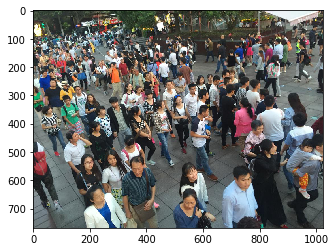

In [71]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [72]:
img = cv2.resize(img, (720, 480), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 3, 480, 720))
timg = torch.from_numpy(img).float().cuda()
out = csr_net(timg)
out.sum().item()

362.0940856933594

In [73]:
count

300.0